In [ ]:
!pip install matplotlib


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import pandas as pd
import numpy as np
import cv2
import random
import requests
from PIL import Image
from PIL import ImageEnhance
from io import BytesIO
import pickle

# preprocess images
def preprocess_image(url):

    response = requests.get(url)
    if response.status_code == 200:

        # open the image
        image = Image.open(BytesIO(response.content))

        # increasing contrast
        image = ImageEnhance.Contrast(image).enhance(1.2)

        # increasing brightness
        image = ImageEnhance.Brightness(image).enhance(1.3)

        # # Rotate the image by 30 degrees
        #image = image.rotate(90)

        # converting to numpy array
        image_array = np.array(image)

        # resizing the image to a standard size using INTER_AREA interpolation
        image_array = cv2.resize(image_array, (224, 224), interpolation=cv2.INTER_AREA)

        # Random flips
        # if random.choice([True, False]):
        #     image_array = cv2.flip(image_array, 1)  # Horizontal flip

        # Brightness and exposure
        # brightness_factor = random.uniform(1.0, 1.3)  # Increase brightness
        # contrast_factor = random.uniform(1.3, 1.6)    # Decrease contrast
        # image_array = cv2.convertScaleAbs(image_array, alpha=contrast_factor, beta=brightness_factor)

        # image_array = cv2.convertScaleAbs(image_array, alpha=1.1, beta=13)

        # normalizing the pixel values
        # image_array = image_array / 255.0

        return image_array
    else:
        print("Invalid URL:", url)
        return None

# loading the data from csv file
data = pd.read_csv('/content/drive/MyDrive/CSE508_Winter2024_A2_MT23029/A2_Data.csv', header=None)

# list for storing pre-processed images
preprocessed_data = []

# iterate through every row
for index, row in data.iterrows():
    # extract the url in list seperated by comma
    urls = row[1].strip("[]").replace("'", "").split(", ")
    review = row[2]
    # perfrom processing on each url
    for url in urls:
        # check for valid url
        if url.strip().startswith('http'):
            # preprocess image
            preprocessed_image = preprocess_image(url.strip())
            if preprocessed_image is not None:
                # append the image_array to pre-processed data
                preprocessed_data.append({'id': row[0], 'image_url': url.strip(), 'review': review, 'preprocessed_image': preprocessed_image})

# save the preprocessed data to a pickle file
with open('/content/drive/MyDrive/CSE508_Winter2024_A2_MT23029/preprocessed_images.pkl', 'wb') as f:
    pickle.dump(preprocessed_data, f)

# Print the length of the pickle file
print("Length of the pickle file:", len(preprocessed_data))


Invalid URL: https://images-na.ssl-images-amazon.com/images/I/71F3npeHUDL._SY88.jpg
Invalid URL: https://images-na.ssl-images-amazon.com/images/I/71wHUWncMGL._SY88.jpg
Invalid URL: https://images-na.ssl-images-amazon.com/images/I/71B8OOE5N8L._SY88.jpg
Invalid URL: https://images-na.ssl-images-amazon.com/images/I/81SX3oAWbNL._SY88.jpg
Invalid URL: https://images-na.ssl-images-amazon.com/images/I/718niQ1GEwL._SY88.jpg
Invalid URL: https://images-na.ssl-images-amazon.com/images/I/61OboZT-kcL._SY88.jpg
Invalid URL: https://images-na.ssl-images-amazon.com/images/I/710a2Pyh5lL._SY88.jpg
Invalid URL: https://images-na.ssl-images-amazon.com/images/I/816NMd0LexL._SY88.jpg
Length of the pickle file: 1640


1640


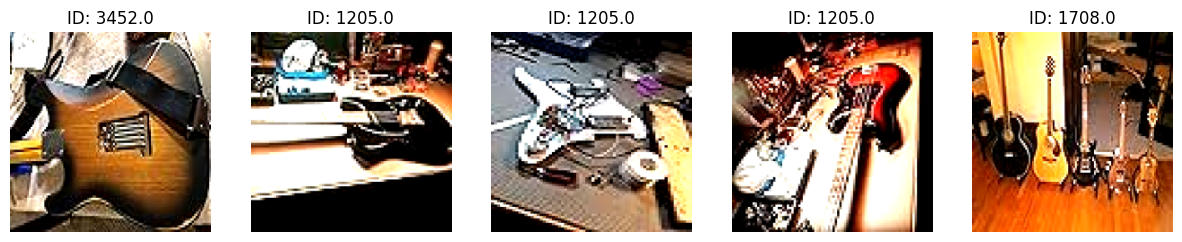

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

# loading the preprocessed images
with open('/content/drive/MyDrive/CSE508_Winter2024_A2_MT23029/preprocessed_images.pkl', 'rb') as f:
    preprocessed_data = pickle.load(f)

# extracting images and IDs
preprocessed_images = [item['preprocessed_image'] for item in preprocessed_data]
print(len(preprocessed_images))
ids = [item['id'] for item in preprocessed_data]

# plotting 5 sample images
num = 5
fig, axes = plt.subplots(1, num, figsize=(15, 5))

for i in range(num):
    # reshape the flattened image back to its original shape
    img_shape = (224, 224, 3)
    reshaped_img = preprocessed_images[i].reshape(img_shape)

    # plot the image
    axes[i].imshow(reshaped_img)

    # add title with ID
    axes[i].set_title(f'ID: {ids[i]}')
    axes[i].axis('off')

plt.show()


In [12]:
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.applications.resnet50 import ResNet50

# Load preprocessed data from pickle file
with open('/content/drive/MyDrive/CSE508_Winter2024_A2_MT23029/preprocessed_images.pkl', 'rb') as f:
    preprocessed_data = pickle.load(f)

# Extract preprocessed images
preprocessed_images = [item['preprocessed_image'] for item in preprocessed_data]

# Reshape images back to their original format
image_shape = (256, 256, 3)
reshaped_images = np.array([img.reshape(image_shape) for img in preprocessed_images])

# Load ResNet50 model without top classification layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256,256, 3))

# Extract features using ResNet50
features = base_model.predict(reshaped_images, verbose=1)

# Flatten features
flattened_features = features.reshape(features.shape[0], -1)

# Normalize flattened features
scaler = StandardScaler()
extracted_features = scaler.fit_transform(flattened_features)

print(extracted_features.shape)


# Save the normalized features to a new pickle file
with open('/content/drive/MyDrive/CSE508_Winter2024_A2_MT23029/normalized_features.pkl', 'wb') as f:
    pickle.dump(extracted_features, f)



52/52 [==============================] - 421s 8s/step
(1640, 131072)


In [5]:
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

# loading the preprocessed pickle file
with open('/content/drive/MyDrive/CSE508_Winter2024_A2_MT23029/preprocessed_images.pkl', 'rb') as f:
    preprocessed_data = pickle.load(f)

# extracting the preprocessed images
preprocessed_images = [item['preprocessed_image'] for item in preprocessed_data]

# reshaping images back to their original format
image_shape = (224, 224, 3)
reshaped_images = np.array([img.reshape(image_shape) for img in preprocessed_images])

# loading MobileNetV2 model without top classification layers
mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# extracting features using MobileNetV2
feat = mobilenet_model.predict(preprocess_input(reshaped_images), verbose=1)

# flatten the features
flat_feat = feat.reshape(feat.shape[0], -1)

# normalizing the extracted features
# scaler = StandardScaler()
# normalized_features = scaler.fit_transform(flattened_features)

# Compute the L2 norm of each feature vector
# feature_norms = np.linalg.norm(flattened_features, axis=1, keepdims=True)
# normalized_features = flattened_features / feature_norms


print("Image Feature Vector:")
for i in range(5):
    print("Image", i+1, ":", flat_feat[i][:10], "... (Shape:", flat_feat[i].shape, ")")



scaler = MinMaxScaler()
norm_feat = scaler.fit_transform(flat_feat)

print("Normalized Feature Vector:")
for i in range(5):
    print("Image", i+1, ":", norm_feat[i][:10])

# saving the normalized features to a pickle file
with open('/content/drive/MyDrive/CSE508_Winter2024_A2_MT23029/normalized_features.pkl', 'wb') as f:
    pickle.dump(norm_feat, f)


52/52 [==============================] - 72s 1s/step
Image Feature Vector:
Image 1 : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ... (Shape: (62720,) )
Image 2 : [0.         0.         0.         0.         1.5307422  0.
 0.         2.7726684  0.20172024 0.        ] ... (Shape: (62720,) )
Image 3 : [0.        0.        0.        0.        0.        0.        0.
 1.4371486 0.        0.       ] ... (Shape: (62720,) )
Image 4 : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ... (Shape: (62720,) )
Image 5 : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ... (Shape: (62720,) )
Normalized Feature Vector:
Image 1 : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Image 2 : [0.         0.         0.         0.         0.33417895 0.
 0.         0.4621114  0.03599207 0.        ]
Image 3 : [0.         0.         0.         0.         0.         0.
 0.         0.23952477 0.         0.        ]
Image 4 : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Image 5 : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [4]:
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.applications.resnet import ResNet101

# Load preprocessed data from pickle file
with open('/content/drive/MyDrive/CSE508_Winter2024_A2_MT23029/preprocessed_images.pkl', 'rb') as f:
    preprocessed_data = pickle.load(f)

# Extract preprocessed images
preprocessed_images = [item['preprocessed_image'] for item in preprocessed_data]

# Reshape images back to their original format
image_shape = (224, 224, 3)
reshaped_images = np.array([img.reshape(image_shape) for img in preprocessed_images])

# Load ResNet101 model without top classification layers
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Extract features using ResNet101
features = base_model.predict(reshaped_images, verbose=1)

# Flatten features
flattened_features = features.reshape(features.shape[0], -1)

# Normalize flattened features
# scaler = StandardScaler()
# extracted_features = scaler.fit_transform(flattened_features)

# feature_norms = np.linalg.norm(flattened_features, axis=1, keepdims=True)

# # Normalize the extracted features
# extracted_features = flattened_features / feature_norms
scaler = MinMaxScaler()
extracted_features = scaler.fit_transform(flattened_features)

print(extracted_features.shape)

# Save the normalized features to a new pickle file
with open('/content/drive/MyDrive/CSE508_Winter2024_A2_MT23029/normalized_features.pkl', 'wb') as f:
    pickle.dump(extracted_features, f)


52/52 [==============================] - 489s 9s/step
(1640, 100352)


In [2]:
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load preprocessed data from pickle file
with open('/content/drive/MyDrive/CSE508_Winter2024_A2_MT23029/preprocessed_images.pkl', 'rb') as f:
    preprocessed_data = pickle.load(f)

# Extract preprocessed images
preprocessed_images = [item['preprocessed_image'] for item in preprocessed_data]

# Reshape images back to their original format
image_shape = (256, 256, 3)
reshaped_images = np.array([img.reshape(image_shape) for img in preprocessed_images])

# Load VGG16 model without top classification layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Extract features using VGG16
features = base_model.predict(preprocess_input(reshaped_images), verbose=1)

# Flatten the features
flattened_features = features.reshape(features.shape[0], -1)

# Normalize the extracted features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(flattened_features)

# Save the normalized features to a new pickle file
with open('/content/drive/MyDrive/CSE508_Winter2024_A2_MT23029/normalized_features.pkl', 'wb') as f:
    pickle.dump(normalized_features, f)


52/52 [==============================] - 1326s 25s/step


In [2]:
import csv
import numpy as np
import pickle

# loading normalized features pickle file
with open('/content/drive/MyDrive/CSE508_Winter2024_A2_MT23029/normalized_features.pkl', 'rb') as f:
    normalized_features = pickle.load(f)

# loading preprocessed data from pickle file
with open('/content/drive/MyDrive/CSE508_Winter2024_A2_MT23029/preprocessed_images.pkl', 'rb') as f:
    preprocessed_data = pickle.load(f)

with open('/content/drive/MyDrive/CSE508_Winter2024_A2_MT23029/extracted_features.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write header row
    header_row = ['id', 'image_url', 'review', 'normalized_features']
    writer.writerow(header_row)

    # Write data row by row
    for i in range(len(preprocessed_data)):
        id = preprocessed_data[i]['id']
        image_url = preprocessed_data[i]['image_url']
        review = preprocessed_data[i]['review']
        features = normalized_features[i]

        # Construct data row
        data_row = [id, image_url, review, list(features)]
        writer.writerow(data_row)

print("Combined data with features saved to extracted_features.csv.")


Combined data with features saved to extracted_features.csv.


In [3]:
import csv
import sys
import pickle

# Set the field size limit to a larger value
csv.field_size_limit(sys.maxsize)

# List to store data
data = []

# Read data from CSV file
with open('/content/drive/MyDrive/CSE508_Winter2024_A2_MT23029/extracted_features.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        data.append(row)

# Save the data to a pickle file
with open('/content/drive/MyDrive/CSE508_Winter2024_A2_MT23029/extracted_features.pkl', 'wb') as f:
    pickle.dump(data, f)

print("Data saved to extracted_features.pkl.")


Data saved to extracted_features.pkl.


In [ ]:
!pip install keras tensorflow